In [37]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt

In [38]:
class CNN(LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

    def accuracy(self, y_hat, y):
        pred = torch.argmax(y_hat, dim=1)
        return (pred == y).float().mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("train loss", loss)
        self.log("train accuracy", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("validation loss", loss)
        self.log("validation accuracy", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y) * 100.0
        self.log("loss", loss)
        self.log("accuracy", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.01)


model = CNN()

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = datasets.CIFAR10(
    root="./data", download=True, train=True, transform=transform
)

test_set = datasets.CIFAR10(
    root="./data", download=True, train=False, transform=transform
)

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

trainer = Trainer(max_epochs=27)

In [40]:
trainer.fit(model, train_loader, ckpt_path="last")
trainer.test(model, train_loader)
trainer.test(model, test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type        | Params
-----------------------------------------
0 | conv1    | Conv2d      | 448   
1 | bn1      | BatchNorm2d | 32    
2 | conv2    | Conv2d      | 4.6 K 
3 | bn2      | BatchNorm2d | 64    
4 | conv3    | Conv2d      | 18.5 K
5 | bn3      | BatchNorm2d | 128   
6 | fc1      | Linear      | 512 K 
7 | dropout1 | Dropout     | 0     
8 | fc2      | Linear      | 5.0 K 
-----------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=27` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     74.83799743652344     │
│           loss            │    0.7381773591041565     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     71.4000015258789      │
│           loss            │    0.8251876831054688     │
└───────────────────────────┴───────────────────────────┘

[{'loss': 0.8251876831054688, 'accuracy': 71.4000015258789}]

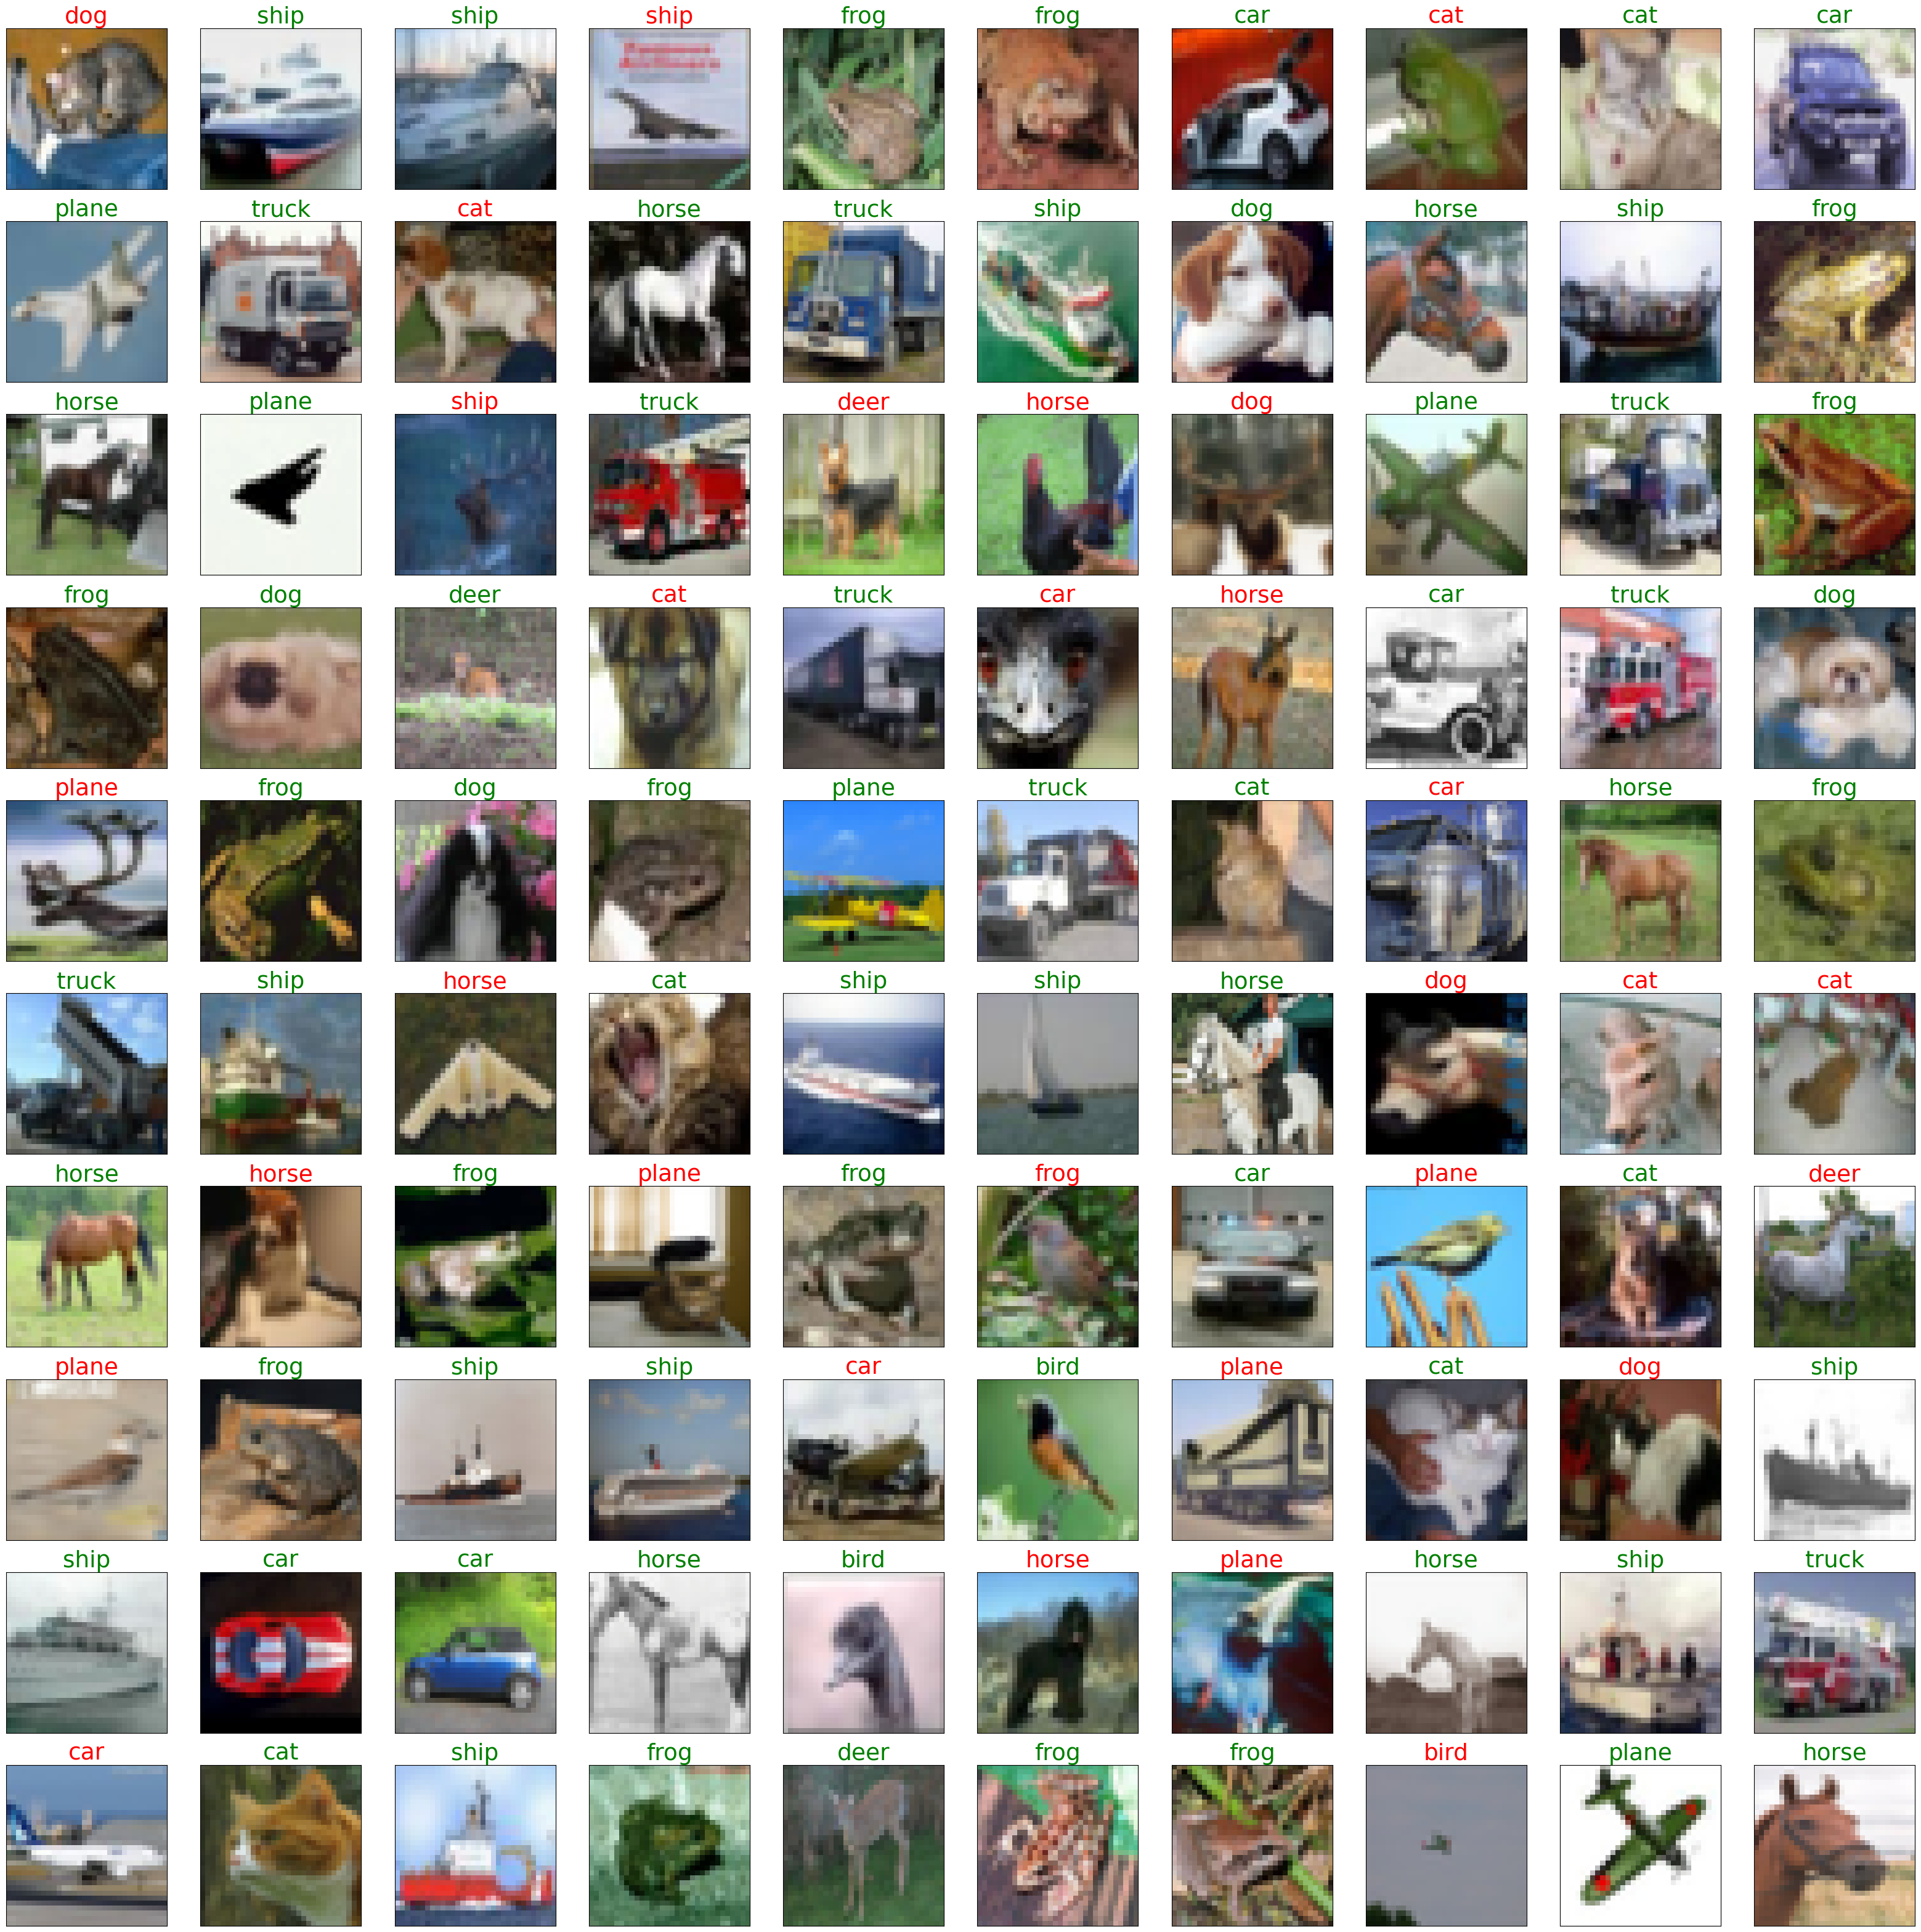

In [41]:
def get_output_label(label):
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )

    return classes[label]


def unnormalize(img):
    mean = torch.Tensor((0.4914, 0.4822, 0.4465)).unsqueeze(1).unsqueeze(2)
    std = torch.Tensor((0.2023, 0.1994, 0.2010)).unsqueeze(1).unsqueeze(2)
    img = img * std + mean
    return torch.clamp(img, 0, 1)


def plot_images(model, images, labels, output_label):
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    plt.figure(figsize=(40, 40))
    for i in range(len(images)):
        img = unnormalize(images[i]).permute(1, 2, 0)
        plt.subplot(10, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap="gray")
        plt.title(
            "{}".format(output_label(predictions[i])),
            fontsize=27,
            color=("green" if predictions[i] == labels[i] else "red"),
        )
    plt.show()


images, labels = next(iter(test_loader))
plot_images(model, images, labels, get_output_label)